In [138]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
import itertools
import matplotlib.dates as mdates

In [139]:
df = pd.read_csv(r'...monthly-car-sales.csv')

In [140]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [141]:
df.set_index(pd.to_datetime(df['Month']),
            inplace=True)

In [142]:
df = df.resample('M').agg({'Sales': np.sum})

In [143]:
df.dropna(inplace=True)

In [144]:
df.reset_index(inplace=True)

In [145]:
df.rename(columns = {'Month': 'ds','Sales': 'y'},inplace=True)

### Первая простая модель

In [146]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<ipython-input-147-d929e4e8c99a>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)
<ipython-input-147-d929e4e8c99a>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


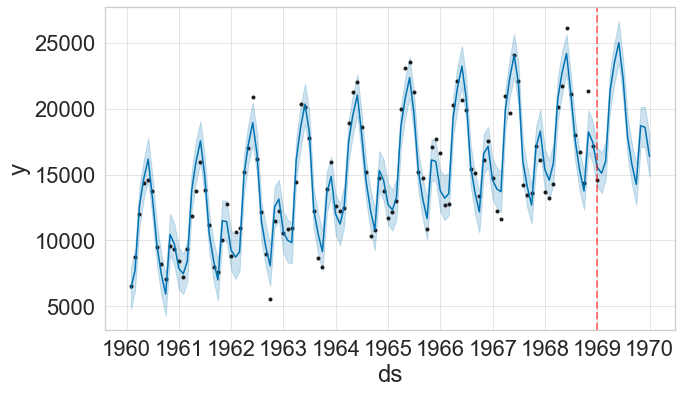

In [147]:
fig = m.plot(forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('365 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

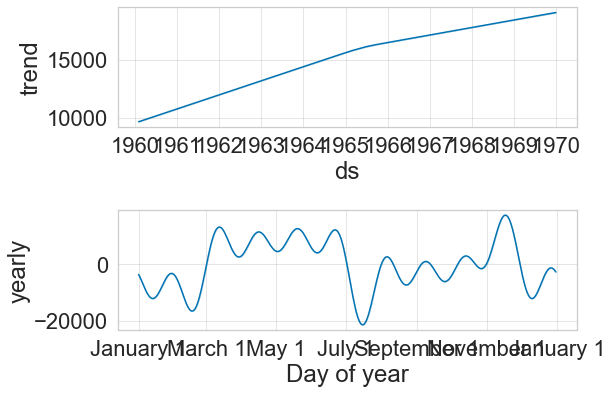

In [148]:
fig = m.plot_components(forecast)

### Кросс-валидация

In [149]:
df_cv = cross_validation(m,horizon='365 days')

INFO:fbprophet:Making 10 forecasts with cutoffs between 1963-07-03 12:00:00 and 1968-01-01 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

In [150]:
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']

In [151]:
df_cv1 = df_cv[df_cv['cutoff']==df_cv['cutoff'].unique()[0]]

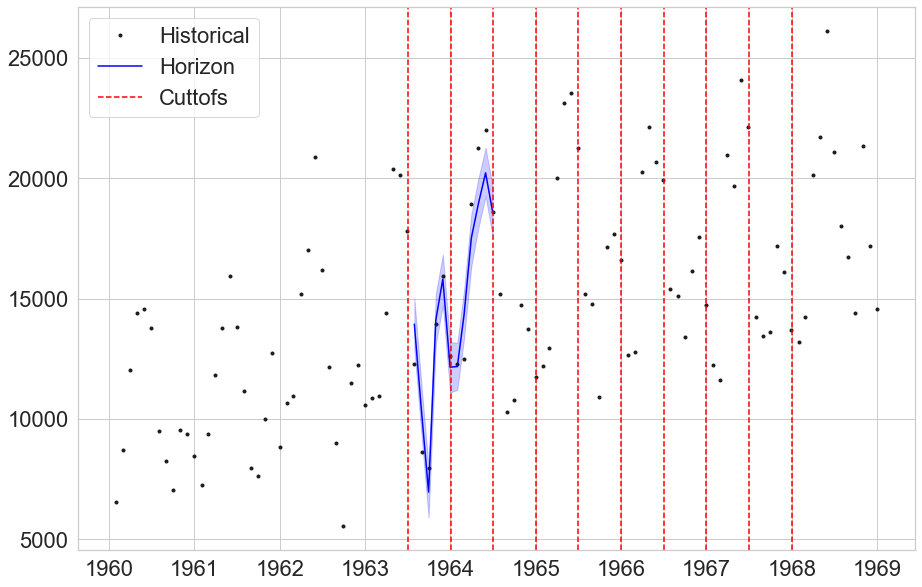

In [152]:
fig, ax = plt.subplots()

ax.plot(m.history['ds'], m.history['y'], 'k.', label = 'Historical')
ax.plot(df_cv1['ds'], df_cv1['yhat'], ls = '-', label = 'Horizon', color='blue')
ax.fill_between(df_cv1['ds'],
               df_cv1['yhat_lower'],
               df_cv1['yhat_upper'],
               color = 'blue',
               alpha = 0.2)
for i in range(len(cutoffs)):
    plt_dict = {'x': cutoffs[i],
               'c': 'red',
                'ls':'--'
               }
    if i == 0:
        plt_dict['label'] = 'Cuttofs'
    ax.axvline(**plt_dict)
ax.legend()
plt.show()

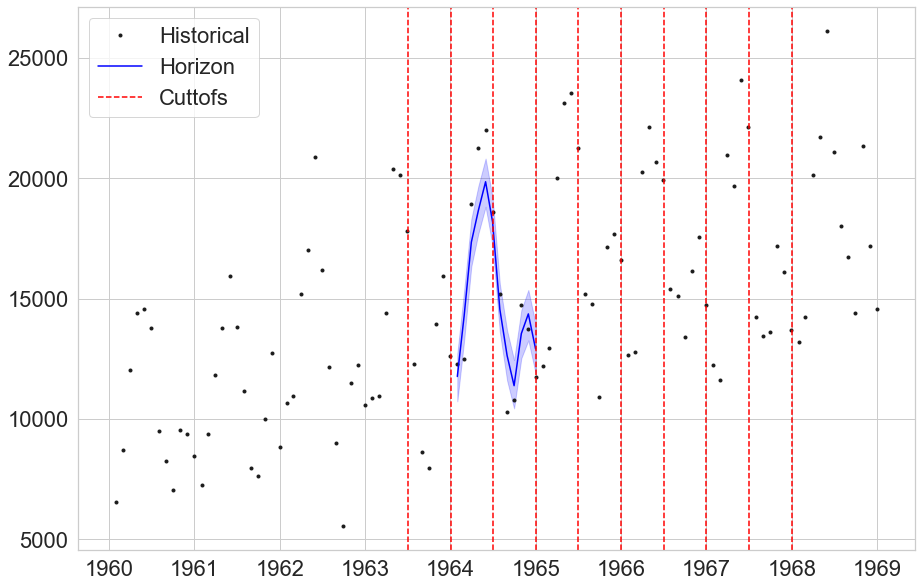

In [153]:
df_cv2 = df_cv[df_cv['cutoff']==df_cv['cutoff'].unique()[1]]

fig, ax = plt.subplots()

ax.plot(m.history['ds'], m.history['y'], 'k.', label = 'Historical')
ax.plot(df_cv2['ds'], df_cv2['yhat'], ls = '-', label = 'Horizon', color='blue')
ax.fill_between(df_cv2['ds'],
               df_cv2['yhat_lower'],
               df_cv2['yhat_upper'],
               color = 'blue',
               alpha = 0.2)
for i in range(len(cutoffs)):
    plt_dict = {'x': cutoffs[i],
               'c': 'red',
                'ls':'--'
               }
    if i == 0:
        plt_dict['label'] = 'Cuttofs'
    ax.axvline(**plt_dict)
ax.legend()
plt.show()

In [154]:
#metrics 

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,58 days 00:00:00,4.294424e+06,2072.299100,1855.706705,0.145541,0.115030,0.291667
1,58 days 12:00:00,4.336976e+06,2082.540770,1882.194212,0.153941,0.129516,0.250000
2,59 days 00:00:00,4.380964e+06,2093.075183,1909.117312,0.156129,0.129749,0.208333
3,59 days 12:00:00,4.331198e+06,2081.152932,1912.270550,0.157947,0.120236,0.208333
4,88 days 12:00:00,4.024365e+06,2006.081959,1825.656418,0.154818,0.125186,0.270833


In [155]:
m = Prophet(yearly_seasonality=True,daily_seasonality=True)

In [156]:
m.fit(df)
forecast = m.predict(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


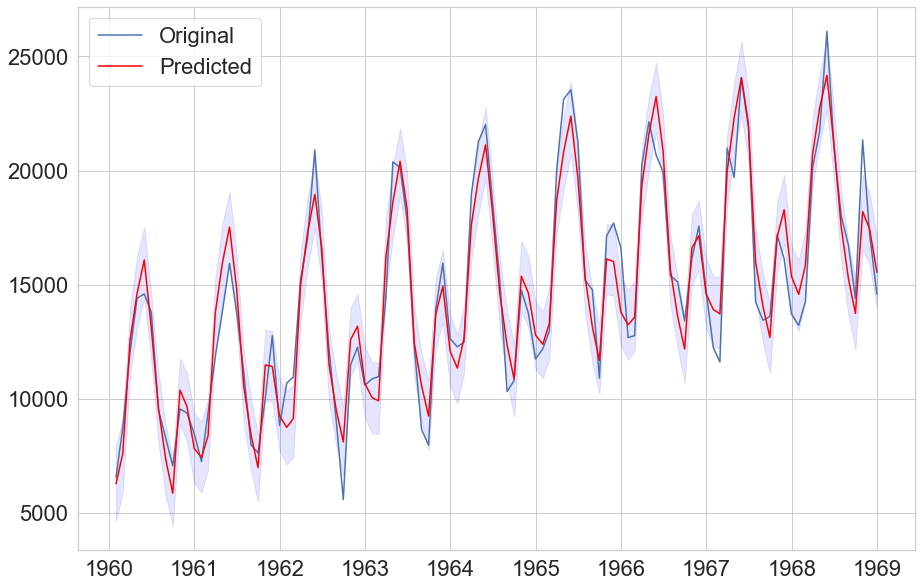

In [157]:
fig, ax = plt.subplots()
ax.plot(df['ds'], df['y'], label = 'Original')
ax.plot(forecast['ds'],forecast['yhat'], label = 'Predicted', color='red')
ax.fill_between(forecast['ds'],forecast['yhat_lower'],forecast['yhat_upper'],
               color = 'blue',
               alpha=0.1)
ax.legend()
plt.show()

In [158]:
df_cv = cross_validation(m,horizon='365 days')

INFO:fbprophet:Making 10 forecasts with cutoffs between 1963-07-03 12:00:00 and 1968-01-01 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

In [159]:
df_p = performance_metrics(df_cv)

In [160]:
df_p.mean()

horizon     211 days 07:05:27.272727272
mse                      3672532.153716
rmse                        1891.087358
mae                         1596.162063
mape                           0.101745
mdape                          0.089023
coverage                       0.455492
dtype: object

In [161]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

In [162]:
def getPerfomanceMetrics(m):
    return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
    return cross_validation(m, horizon = '365 days')

In [163]:
def single_cv_run(data, metrics, param_dict, parallel):
    m = Prophet(**param_dict)

    m.fit(data)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [164]:
param_grid = {                  
                'changepoint_prior_scale': [0.01],
                'changepoint_range': [0.3],
                'seasonality_prior_scale':[0.5],
                'yearly_seasonality':[20],
                'weekly_seasonality':[5],
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
results = []

In [165]:
params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df,  metrics, param_dict, parallel="processes")
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 1963-07-03 12:00:00 and 1968-01-01 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



 The best param combination is {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.3, 'seasonality_prior_scale': 0.5, 'yearly_seasonality': 20.0, 'weekly_seasonality': 5.0}


horizon    365 days 00:00:00
rmse              2321.87112
mae              1868.061281
mape                0.121164
mdape               0.110435
dtype: object